Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
root_path = 'gdrive/My Drive/malonam_detection/'

In [4]:
!unzip gdrive/MyDrive/malonam_detection/CNN_assignment.zip -d gdrive/MyDrive/malonam_detection/CNN_Assignment

Archive:  gdrive/MyDrive/malonam_detection/CNN_assignment.zip
  inflating: gdrive/MyDrive/malonam_detection/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: gdrive/MyDrive/malonam_detection/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: gdrive/MyDrive/malonam_detection/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: gdrive/MyDrive/malonam_detection/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: gdrive/MyDrive/malonam_detection/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: gdrive/MyDrive/malonam_detection/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Coll

In [5]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("gdrive/MyDrive/malonam_detection/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('gdrive/MyDrive/malonam_detection/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # 20% of the data will be used for validation
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # 20% of the data will be used for validation
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# The class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualize one instance of all the nine classes present in the dataset

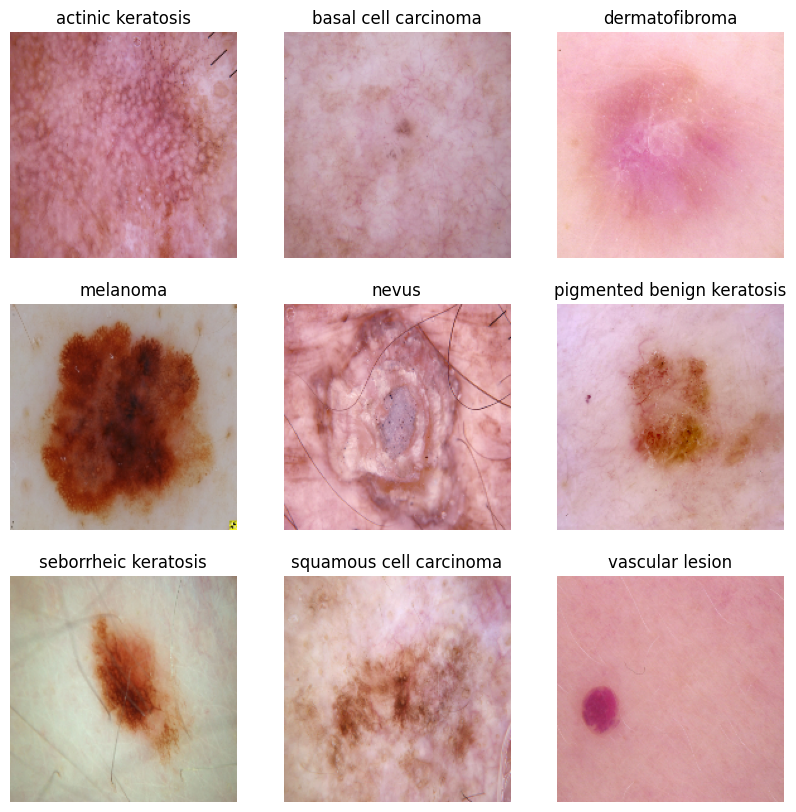

In [11]:
import matplotlib.pyplot as plt
num_classes_to_plot = 9
plt.figure(figsize=(10, 10))

for i in range(num_classes_to_plot):
    for images, labels in train_ds:
        if len(set(labels.numpy())) < num_classes_to_plot:
            continue
        image = images[labels.numpy() == i][0]  # Select one image from class i
        plt.subplot(3, 3, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(class_names[i])
        plt.axis("off")
        break  # Move to the next class

plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset.

In [26]:
### Model code goes here
# Rescale pixel values to be between 0 and 1
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Flatten(),

  layers.Dense(128, activation='relu'),

  layers.Dense(num_classes)

])


### Compile the model

In [27]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
# View the summary of all layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 90, 90, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 45, 45, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 45, 45, 64)       

### Train the model

In [29]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 67ms/step - loss: 2.1292 - accuracy: 0.2065 - val_loss: 1.9739 - val_accuracy: 0.2506
Epoch 2/20
56/56 [==============================] - 3s 59ms/step - loss: 1.8871 - accuracy: 0.3036 - val_loss: 1.6952 - val_accuracy: 0.4340
Epoch 3/20
56/56 [==============================] - 3s 59ms/step - loss: 1.7181 - accuracy: 0.3683 - val_loss: 1.7483 - val_accuracy: 0.3579
Epoch 4/20
56/56 [==============================] - 3s 60ms/step - loss: 1.5953 - accuracy: 0.4392 - val_loss: 1.5471 - val_accuracy: 0.4855
Epoch 5/20
56/56 [==============================] - 3s 59ms/step - loss: 1.5076 - accuracy: 0.4609 - val_loss: 1.5570 - val_accuracy: 0.4810
Epoch 6/20
56/56 [==============================] - 3s 59ms/step - loss: 1.4014 - accuracy: 0.4939 - val_loss: 1.4913 - val_accuracy: 0.4966
Epoch 7/20
56/56 [==============================] - 3s 59ms/step - loss: 1.2746 - accuracy: 0.5536 - val_loss: 1.4493 - val_accuracy: 0.5324
Epoch 8/20
56

### Visualizing training results

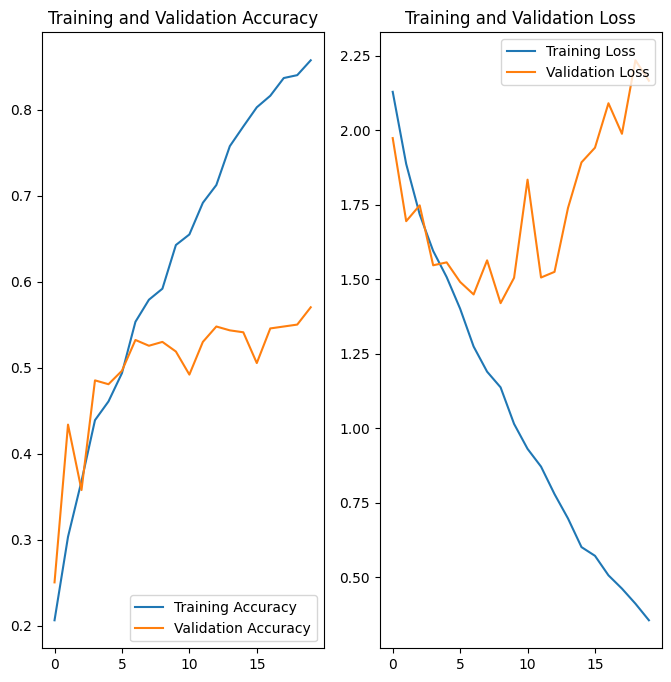

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### 1. After 20 epochs, training accuracy is 85%, but validation accuracy is only 57%, which shows model is overfitting.

In [31]:
### Data augumentation strategy.
# To reduce the overfitting problem we manupulate the images using data augmentation
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    layers.experimental.preprocessing.RandomCrop(img_height,img_width),
  ]
)

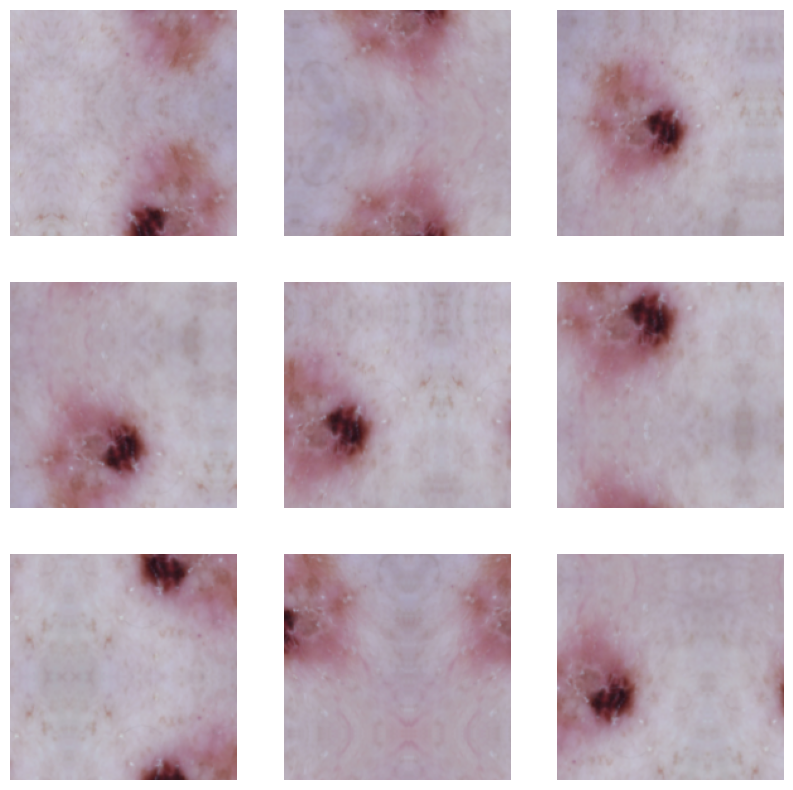

In [32]:
# Visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model, compile and train the model

In [33]:

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.15),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model

In [34]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [35]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 10s 126ms/step - loss: 2.2592 - accuracy: 0.2065 - val_loss: 1.9486 - val_accuracy: 0.3043
Epoch 2/30
56/56 [==============================] - 7s 119ms/step - loss: 1.9429 - accuracy: 0.2673 - val_loss: 1.8446 - val_accuracy: 0.3669
Epoch 3/30
56/56 [==============================] - 7s 116ms/step - loss: 1.8181 - accuracy: 0.3348 - val_loss: 1.7134 - val_accuracy: 0.3132
Epoch 4/30
56/56 [==============================] - 7s 118ms/step - loss: 1.7400 - accuracy: 0.3410 - val_loss: 1.6965 - val_accuracy: 0.3803
Epoch 5/30
56/56 [==============================] - 6s 115ms/step - loss: 1.6824 - accuracy: 0.3588 - val_loss: 1.6293 - val_accuracy: 0.3870
Epoch 6/30
56/56 [==============================] - 7s 118ms/step - loss: 1.6689 - accuracy: 0.3683 - val_loss: 1.6470 - val_accuracy: 0.3937
Epoch 7/30
56/56 [==============================] - 6s 114ms/step - loss: 1.6477 - accuracy: 0.3845 - val_loss: 1.7652 - val_accuracy: 0.3020
Epoch

### Visualizing the results

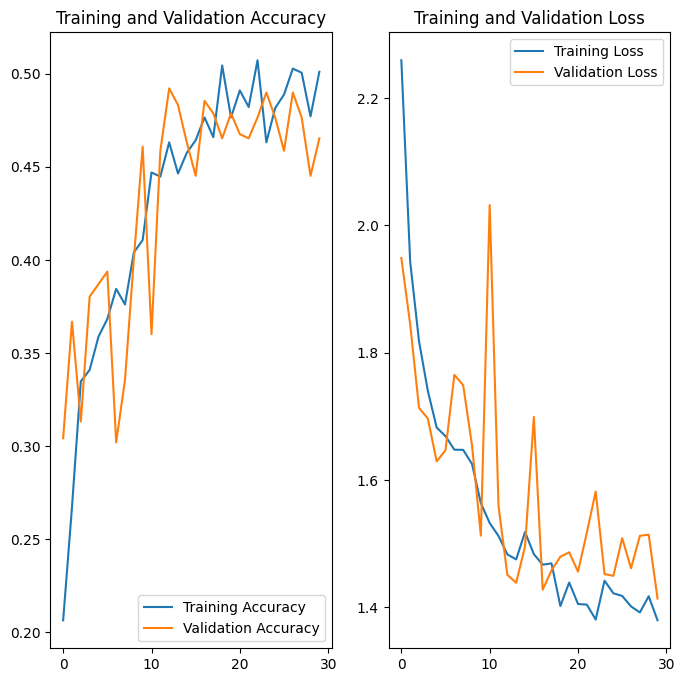

In [37]:
import matplotlib.pyplot as plt
epochs=30
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)



plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### After applying augmentation of images, we can see from above graph that difference between training validation accuracy has reduced.
#### We have applied dropout layer to reduce overfitting.

#### The distribution of classes in the training dataset.
#### Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [38]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [39]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,gdrive/MyDrive/malonam_detection/CNN_Assignmen...,actinic keratosis
1,gdrive/MyDrive/malonam_detection/CNN_Assignmen...,actinic keratosis
2,gdrive/MyDrive/malonam_detection/CNN_Assignmen...,actinic keratosis
3,gdrive/MyDrive/malonam_detection/CNN_Assignmen...,actinic keratosis
4,gdrive/MyDrive/malonam_detection/CNN_Assignmen...,actinic keratosis
...,...,...
2234,gdrive/MyDrive/malonam_detection/CNN_Assignmen...,vascular lesion
2235,gdrive/MyDrive/malonam_detection/CNN_Assignmen...,vascular lesion
2236,gdrive/MyDrive/malonam_detection/CNN_Assignmen...,vascular lesion
2237,gdrive/MyDrive/malonam_detection/CNN_Assignmen...,vascular lesion


Class=0, n=114 (5.092%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)
Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)


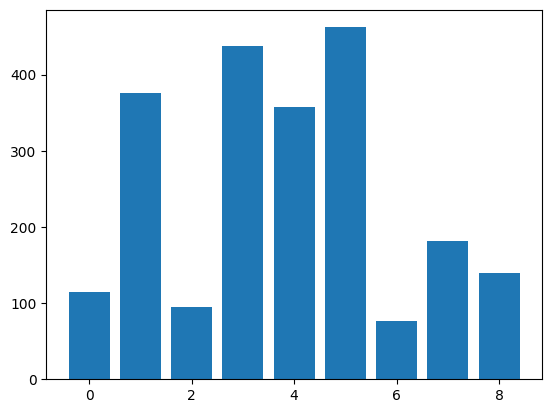

In [40]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

#### - Which class has the least number of samples?
#### Class 6 - seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
#### Class 5 - pigmented benign keratosis



#### Rectify the class imbalance

In [41]:
!pip install Augmentor

In [42]:
path_to_training_dataset="gdrive/MyDrive/malonam_detection/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to gdrive/MyDrive/malonam_detection/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E0F006565F0>: 100%|██████████| 500/500 [00:17<00:00, 29.07 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/MyDrive/malonam_detection/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E0F00657190>: 100%|██████████| 500/500 [00:16<00:00, 29.45 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/MyDrive/malonam_detection/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E0F245A3BB0>: 100%|██████████| 500/500 [00:18<00:00, 27.09 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/MyDrive/malonam_detection/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7E0FB783F9D0>: 100%|██████████| 500/500 [01:23<00:00,  6.01 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/MyDrive/malonam_detection/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2592x1944 at 0x7E0F24F1BE80>: 100%|██████████| 500/500 [01:20<00:00,  6.24 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/MyDrive/malonam_detection/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E0F00639420>: 100%|██████████| 500/500 [00:16<00:00, 30.06 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/MyDrive/malonam_detection/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E0F257FBE80>: 100%|██████████| 500/500 [00:37<00:00, 13.21 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/MyDrive/malonam_detection/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E0F24DE37C0>: 100%|██████████| 500/500 [00:17<00:00, 27.96 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/MyDrive/malonam_detection/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E0F256BBEE0>: 100%|██████████| 500/500 [00:16<00:00, 29.63 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [43]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [44]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['gdrive/MyDrive/malonam_detection/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031040.jpg_ea035061-2f0e-4b64-a42b-02e88d81e829.jpg',
 'gdrive/MyDrive/malonam_detection/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027650.jpg_f89343b4-c204-4420-b345-0785b7a3d2d4.jpg',
 'gdrive/MyDrive/malonam_detection/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029309.jpg_cc1ecb25-3d2c-4bd8-835f-302752716a8c.jpg',
 'gdrive/MyDrive/malonam_detection/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028990.jpg_1699b82b-dea1-47a8-8f11-16dfdb55e5a2.jpg',
 'gdrive/MyDrive/malonam_detection/CNN_Assignment/Skin cancer ISIC The Internati

In [45]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [46]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [47]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-47-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [48]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance.

#### Train the model on the data created after improving class imbalance

In [49]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [50]:
data_dir_train="gdrive/MyDrive/malonam_detection/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size = (img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [51]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create the model

In [99]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
  layers.Flatten(),
layers.Dense(512, activation='relu'),
  layers.Dense(num_classes)
])

#### Compile the model

In [96]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train the model

In [97]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 8s 32ms/step - loss: 1.9072 - accuracy: 0.2671 - val_loss: 1.5903 - val_accuracy: 0.3370
Epoch 2/30
169/169 [==============================] - 5s 30ms/step - loss: 1.5685 - accuracy: 0.3935 - val_loss: 1.4892 - val_accuracy: 0.4091
Epoch 3/30
169/169 [==============================] - 5s 31ms/step - loss: 1.3943 - accuracy: 0.4579 - val_loss: 1.2699 - val_accuracy: 0.5056
Epoch 4/30
169/169 [==============================] - 5s 30ms/step - loss: 1.2626 - accuracy: 0.5163 - val_loss: 1.1505 - val_accuracy: 0.5509
Epoch 5/30
169/169 [==============================] - 5s 32ms/step - loss: 1.1550 - accuracy: 0.5586 - val_loss: 1.1282 - val_accuracy: 0.5694
Epoch 6/30
169/169 [==============================] - 5s 30ms/step - loss: 0.9839 - accuracy: 0.6250 - val_loss: 0.9687 - val_accuracy: 0.6169
Epoch 7/30
169/169 [==============================] - 5s 31ms/step - loss: 0.8441 - accuracy: 0.6836 - val_loss: 0.8766 - val_accuracy: 0.6748

#### **Todo:**  Visualize the model results

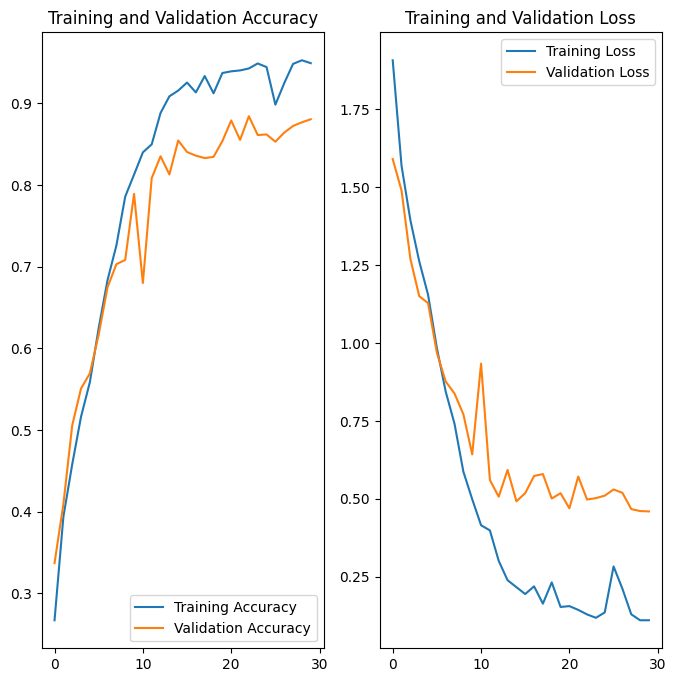

In [98]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### After class resemblance, we can see that overfitting has been reduced severly.
#### Training accuracy and validation accuracy also increased.
#### Similarly loss of both training and validation data has decresed.
#### Overfitting and information loss has been tackled using class resemblance and drop out technique.
#### Overall training accuracy after 30 epochs is 95%, validation accuracy is 88%.
